<a href="https://colab.research.google.com/github/Valent0296/allvent.github.io/blob/master/Food_Delivery_Time_Prediction_RNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Food Delivery Time Prediction is a regression problem, since we want to find a black box law linking input features, and the predicted time taken to deliver food.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append("/MyDrive/dataset/")
import torch
from torch import Tensor
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%cd /content/drive/MyDrive/dataset/
deliverytime = pd.read_csv("deliverytime.txt", sep=",", index_col='ID')


Mounted at /content/drive
/content/drive/MyDrive/dataset


In [2]:
print(deliverytime.head())
deliverytime.info()

     Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
ID                                                                      
4607     INDORES13DEL02                   37                      4.9   
B379     BANGRES18DEL02                   34                      4.5   
5D6D     BANGRES19DEL01                   23                      4.4   
7A6A    COIMBRES13DEL02                   38                      4.7   
70A2     CHENRES12DEL01                   32                      4.6   

      Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
ID                                                                            
4607            22.745049             75.892471                   22.765049   
B379            12.913041             77.683237                   13.043041   
5D6D            12.914264             77.678400                   12.924264   
7A6A            11.003669             76.976494                   11.053669   
70A2          

In [3]:

stats_person = deliverytime[ ['Delivery_person_ID', 'Time_taken(min)'] ].groupby( ['Delivery_person_ID'] ).mean()
stats_person.head()
stats_person = deliverytime

In [4]:


#For categorical data, I'm gonna switch them with their average time taken per vehicle / order
mean_time_deliverer = deliverytime.groupby('Delivery_person_ID')['Time_taken(min)'].mean()
mean_time_veich = deliverytime.groupby('Type_of_vehicle')['Time_taken(min)'].mean()
mean_time_order = deliverytime.groupby('Type_of_order')['Time_taken(min)'].mean()

stats_person = stats_person.join(mean_time_deliverer, on='Delivery_person_ID', rsuffix='Mean_time_deliverer')
stats_person = stats_person.join(mean_time_veich, on='Type_of_vehicle', rsuffix='Mean_time_vehic')
stats_person = stats_person.join(mean_time_order, on='Type_of_order', rsuffix='Mean_time_order')


#Another option was to calulate the relative frequency of each class of vehicle/order


In [5]:
stats_person['Type_of_vehicle'], un_veich = pd.factorize(deliverytime['Type_of_vehicle'])
stats_person['Type_of_order'], un_order = pd.factorize(deliverytime['Type_of_order'])
stats_person['Delivery_person_Age'] = deliverytime['Delivery_person_Age'] * 365 * 24 * 3600
stats_person['Time_taken(min)']  = deliverytime['Time_taken(min)'] * 60
stats_person['Time_taken(min)Mean_time_deliverer'] = stats_person['Time_taken(min)Mean_time_deliverer'] * 60
stats_person['Time_taken(min)Mean_time_order'] = stats_person['Time_taken(min)Mean_time_order'] * 60
stats_person['Time_taken(min)Mean_time_vehic'] = stats_person['Time_taken(min)Mean_time_vehic'] * 60


means = {}
var = {}
for item in stats_person.columns:
  if item != 'Delivery_person_ID' and item != 'Type_of_order' and  item != 'Type_of_vehicle' and item != 'Delivery_person_ratings': #For intervallar or ratio variables I use normalization
    means.update( {item: stats_person[item].mean()})
    var.update({item: stats_person[item].std()})
    stats_person[item] -= stats_person[item].mean()
    stats_person[item] /= stats_person[item].std()
  elif item == 'Delivery_person_ratings': #For ordinal data I use min max scaling
    stats_person[item] -= deliverytime['Delivery_person_ratings'].min()
    stats_person[item] /= (deliverytime['Delivery_person_ratings'].max() - deliverytime['Delivery_person_ratings'].min())

print(var)

{'Delivery_person_Age': 179654062.06206816, 'Delivery_person_Ratings': 0.3277075288383162, 'Restaurant_latitude': 8.185108965214447, 'Restaurant_longitude': 22.883647223093075, 'Delivery_location_latitude': 7.335121994514343, 'Delivery_location_longitude': 21.118811879085786, 'Time_taken(min)': 563.0283687097862, 'Time_taken(min)Mean_time_deliverer': 91.82522109855185, 'Time_taken(min)Mean_time_vehic': 92.51496963020327, 'Time_taken(min)Mean_time_order': 4.939862086479378}


Target Encoding (Mean Encoding)

How it works: This method involves replacing each category with the mean of the target variable for that category. It's typically used in supervised learning.


Example:
Suppose "Vehicle Type" is being used to predict "Fuel Efficiency." Each type would be replaced by the average fuel efficiency of that type.


Pros: Can capture the relationship between the category and the target variable.


Cons: Prone to overfitting, especially with small datasets.

In [6]:

stats_person.drop( 'Type_of_vehicle', axis=1, inplace=True)
stats_person.drop('Type_of_order', axis=1, inplace=True)


#stats_person['Delivery_person_ID'], un_del_id = pd.factorize(deliverytime['Delivery_person_ID']) #For Delivery person Id, I'll use word embeddings, so the first thing to do is to factorize
#print(stats_person.head())
stats_person = stats_person.iloc[:,[10, 1, 2, 3, 4, 5, 6, 8, 9, 7]]

print(stats_person.head())

corr_matr = stats_person.corr()
corr_matr

      Time_taken(min)Mean_time_order  Delivery_person_Age  \
ID                                                          
4607                       -0.100786             1.308793   
B379                       -0.100786             0.782181   
5D6D                       -1.295429            -1.148730   
7A6A                       -0.134773             1.484331   
70A2                       -0.100786             0.431107   

      Delivery_person_Ratings  Restaurant_latitude  Restaurant_longitude  \
ID                                                                         
4607                 0.816683             0.699724              0.247388   
B379                -0.403918            -0.501482              0.325643   
5D6D                -0.709068            -0.501333              0.325432   
7A6A                 0.206383            -0.734756              0.294759   
70A2                -0.098767            -0.494182              0.437808   

      Delivery_location_latitude  Deliv

,Time_taken(min)Mean_time_order,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_taken(min)Mean_time_deliverer,Time_taken(min)Mean_time_vehic,Time_taken(min)
Time_taken(min)Mean_time_order,1.000000,0.003397,-0.002348,-0.005545,-0.004958,-0.001009,-0.004648,0.000189,0.002920,0.008774
Delivery_person_Age,0.003397,1.000000,-0.067449,-0.001955,-0.006796,0.002359,-0.000593,0.050358,-0.000364,0.292708
Delivery_person_Ratings,-0.002348,-0.067449,1.000000,-0.004846,-0.011147,-0.010198,-0.013350,-0.051289,-0.023730,-0.331103
Restaurant_latitude,-0.005545,-0.001955,-0.004846,1.000000,0.661784,0.866378,0.602713,0.070489,0.018418,0.013981
Restaurant_longitude,-0.004958,-0.006796,-0.011147,0.661784,1.000000,0.632293,0.915026,0.043111,0.020893,0.007821
Delivery_location_latitude,-0.001009,0.002359,-0.010198,0.866378,0.632293,1.000000,0.690515,0.077494,0.011014,0.014243
Delivery_location_longitude,-0.004648,-0.000593,-0.013350,0.602713,0.915026,0.690515,1.000000,0.043338,0.011288,0.007625
Time_taken(min)Mean_time_deliverer,0.000189,0.050358,-0.051289,0.070489,0.043111,0.077494,0.043338,1.000000,0.033636,0.163092
Time_taken(min)Mean_time_vehic,0.002920,-0.000364,-0.023730,0.018418,0.020893,0.011014,0.011288,0.033636,1.000000,0.164317
Time_taken(min),0.008774,0.292708,-0.331103,0.013981,0.007821,0.014243,0.007625,0.163092,0.164317,1.000000


In [7]:
###########
# Dataset #
###########
class FDTDataset( Dataset ):

  def __init__(self, data):
    self.data_tensor = data

  def __len__(self):
    return len(self.data_tensor)

  def __getitem__(self, idx):
    data = self.data_tensor[:,:-1]
    label = self.data_tensor[:,-1]
    return data[idx,:], label[idx]


dev = 0.01
test = 0.01
train = 1 - dev - test

data = stats_person.sample(frac=1)
dev_data = data.sample(frac=dev).to_numpy()
test_data = data.sample(frac=test).to_numpy()
train_data = data.sample(frac=train).to_numpy()

dev_label_mean = dev_data[-1].mean()
test_label_mean = test_data[-1].mean()
train_label_mean = train_data[-1].mean()

batch_size = 64

dev_loader = DataLoader(FDTDataset(dev_data), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(FDTDataset(test_data), batch_size=batch_size, shuffle=True)
train_loader = DataLoader(FDTDataset(train_data), batch_size=batch_size, shuffle=True)



In [8]:
class FDTModel(nn.Module):

  def __init__(self, i1_size, i2_size, i3_size, h_size, o1_size, o2_size,  o3_size, out_size):
    super(FDTModel, self).__init__()
    self.i1_size = i1_size
    self.i2_size = i2_size
    self.i3_size = i3_size
    self.h1_size = h_size
    self.o1_size = o1_size
    self.o2_size = o2_size
    self.o3_size = o3_size
    self.out_size = out_size
    #self.vocab_size = vocab_size
   # self.dim_emb = dim_emb
    #self.embed = TokenEmbedding(self.vocab_size, self.dim_emb)
    #Input ID Delivery person, Deliver person age, Delivery person age
    self.rnncellh11 = nn.RNNCell(i1_size, h_size) #No output
    self.rnncello11 = nn.Sequential( nn.Linear(h_size, o1_size), nn.Tanh())
    self.rnncellh12 = nn.RNNCell(o1_size, h_size)
    self.rnncello12 = nn.Sequential( nn.Linear(h_size, o1_size), nn.Softmax(-1))
    self.rnncellh13 = nn.RNNCell(o1_size, h_size)

    #Input previous hidden state, Restaurant, Delivery location
    self.rnncellh21 = nn.RNNCell(i2_size, h_size)
    self.rnncello21 = nn.Sequential( nn.Linear(h_size, o2_size), nn.Tanh() )
    self.rnncellh22 = nn.RNNCell(o2_size, h_size)
    self.rnncello22 = nn.Sequential( nn.Linear(h_size, o2_size), nn.Tanh() )
    self.rnncellh23 = nn.RNNCell(o2_size, h_size)
    self.rnncello23 = nn.Sequential( nn.Linear(h_size, o2_size), nn.Softmax(-1) )

    #Input previous hidden state, previous output, Vehicle time taken avg, Order time taken avg
    self.rnncellh31 = nn.RNNCell(i3_size+o2_size, h_size)
    self.rnncello31 = nn.Sequential( nn.Linear(h_size, o2_size), nn.Tanh())
    self.rnncellh32 = nn.RNNCell(o3_size, h_size)
    self.rnncello32 = nn.Sequential( nn.Linear(h_size, o3_size), nn.Tanh() )
    self.rnncellh33 = nn.RNNCell(o3_size, h_size)
    self.rnncello33 = nn.Sequential( nn.Linear(h_size, o3_size), nn.Tanh() )
    self.linearout = nn.Sequential( nn.Linear(o3_size, out_size), nn.Tanh() )

  def forward(self,x1, x2, x3):
    #id_emb = self.embed(id)
    #x1 = torch.concat([id_emb, x1], axis=-1)
    h11 = self.rnncellh11(x1)
    o11 = self.rnncello11( h11 )
    h12 = self.rnncellh12(o11)
    o12 = self.rnncello12( h12 )
    h13 = self.rnncellh13(o12)

    i2 = x2
    h21 = self.rnncellh21( i2, h11 )
    o21 = self.rnncello21( h21 )
    h22 = self.rnncellh22( o21, h12 )
    o22 = self.rnncello22( h22 )
    h23 = self.rnncellh23( o22, h13 )
    o23 = self.rnncello23( h23 )

    i3 = torch.concat([x3, o23], axis=-1)
    h31 = self.rnncellh31( i3, h21 )
    o31 = self.rnncello31( h31 )
    h32 = self.rnncellh32( o31, h22 )
    o32 = self.rnncello32( h32 )
    h33 = self.rnncellh33( o32, h23 )
    o33 = self.rnncello33( h33 )

    out = self.linearout( o33 )
    return out




In [9]:
loss_list_dev =  []
loss_list_train = []

#Define dev loop
def dev_loop(dataloader, model, loss_fn, optimizer):
  model.train()
  size = len(dataloader.dataset)
  dev_loss, correct = 0.0, 0.0
  num_batches = len(dataloader)
  y_dev = []
  pred_dev = []
  mae = 0.0
  R_squared = 0.0
  for batch, (X, y) in enumerate(dataloader):
    batch_size, batch_correct = 0, 0
    X, y = X.to(device).to(torch.float), y.to(device).to(torch.float)
    #Compute prediction and loss
    pred = model(X[:,[0, 1, 2]], X[:, [3, 4, 5, 6]], X[:,[7, 8]]) #La prediction andrebbe denormalizzata essendo l'output
    RSS = np.power((y.detach() - pred.detach()), 2).sum()
    TSS = np.power((y.detach() - y.mean()), 2).sum()
    r_square = 1 - RSS/TSS
    R_squared += r_square
    orig_y = torch.add(torch.multiply(y, var.get('Time_taken(min)')) , means.get('Time_taken(min)'))/60
    orig_pred = torch.add(torch.multiply(pred, var.get('Time_taken(min)')) , means.get('Time_taken(min)'))/60

    y_dev.append(orig_y)
    pred_dev.append(orig_pred)
    loss = loss_fn(pred.squeeze(), y)
    dev_loss += loss
    batch_size = X.size(0)
    mae += np.abs(orig_y.detach() - orig_pred.detach()).sum()
    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list_dev.append(loss.item()) #


  mae /= size
  R_squared /= num_batches
  print(f"Errore dev:  Media loss (Scarto quadratico della stima): {dev_loss**(1/2):>8f} \nErrore assoluto medio: {mae:>8f}\nCoefficiente di determinazione: {R_squared}")
  return dev_loss**(1/2)

#Define train loop
def train_loop(dataloader, model, loss_fn, optimizer):
  model.train()
  size = len(dataloader.dataset)
  train_loss, correct = 0.0, 0.0
  num_batches = len(dataloader)
  y_train = []
  pred_train = []
  mae = 0.0
  R_squared = 0.0
  for batch, (X, y) in enumerate(dataloader):
    batch_size, batch_correct = 0, 0
    X, y = X.to(device).to(torch.float), y.to(device).to(torch.float)
    #Compute prediction and loss
    pred = model(X[:,[0, 1, 2]], X[:, [3, 4, 5, 6]], X[:,[7, 8]]) #La prediction andrebbe denormalizzata essendo l'output
    RSS = np.power((y.detach() - pred.detach()), 2).sum()
    TSS = np.power((y.detach() - y.mean()), 2).sum()
    r_square = 1 - RSS/TSS
    R_squared += r_square
    orig_y = torch.add(torch.multiply(y, var.get('Time_taken(min)')) , means.get('Time_taken(min)'))/60
    orig_pred = torch.add(torch.multiply(pred, var.get('Time_taken(min)')) , means.get('Time_taken(min)'))/60

    y_train.append(orig_y)
    pred_train.append(orig_pred.squeeze())
    loss = loss_fn(pred.squeeze(), y)
    train_loss += loss
    batch_size = X.size(0)
    mae += np.abs(orig_y.detach() - orig_pred.detach()).sum()
    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list_train.append(loss.item()) #

  mae /= size
  R_squared /= num_batches
  #dev_loss /= num_batches
  print(f"Errore train:  Media loss (Scarto quadratico della stima): {train_loss**(1/2):>8f} \nErrore assoluto medio: {mae:>8f}\nCoefficiente di determinazione: {R_squared}")

  return train_loss**(1/2), y_train, pred_train, mae

#Define test loop
def test_loop(dataloader, model, loss_fn):
  model.eval()
  size = len(dataloader.dataset)
  test_loss, correct = 0.0, 0.0
  num_batches = len(dataloader)
  y_test = []
  pred_test = []
  mae = 0.0
  R_squared = 0.0
  for batch, (X, y) in enumerate(dataloader):
    batch_size, batch_correct = 0, 0
    X, y = X.to(device).to(torch.float), y.to(device).to(torch.float)
    #Compute prediction and loss
    pred = model(X[:,[0, 1, 2]], X[:, [3, 4, 5, 6]], X[:,[7, 8]]) #La prediction andrebbe denormalizzata essendo l'output
    RSS = np.power((y.detach() - pred.detach()), 2).sum()
    TSS = np.power((y.detach() - y.mean()), 2).sum()
    r_square = 1 - RSS/TSS
    R_squared += r_square

    orig_y = torch.add(torch.multiply(y, var.get('Time_taken(min)')) , means.get('Time_taken(min)'))/60
    orig_pred = torch.add(torch.multiply(pred, var.get('Time_taken(min)')) , means.get('Time_taken(min)'))/60

    y_test.append(orig_y)
    pred_test.append(orig_pred.squeeze())
    loss = loss_fn(pred.squeeze(), y)
    test_loss += loss
    batch_size = X.size(0)
    mae += np.abs(orig_y.detach() - orig_pred.detach()).sum()

  mae /= size
  R_squared /= num_batches
  #dev_loss /= num_batches
  print(f"Errore test:  Media loss (Scarto quadratico della stima): {test_loss**(1/2):>8f} \nErrore assoluto medio: {mae:>8f}\nCoefficiente di determinazione: {R_squared}")

  return test_loss**(1/2), y_test, pred_test, mae

In [10]:
#Definiamo la loss function, metodo di minimizzazione e iperparametri
learning_rate = [i*10**(-i) for i in range(1,5)]
momentum = [i/10 for i in range(10)]
lr_mom_grid = [(l,m, 0) for l in learning_rate for m in momentum]

loss_fn = nn.MSELoss()

model_RNN = FDTModel(3, 4, 2,  32, 64, 64, 64, 1)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight).to(device)
        m.bias.data.fill_(0.01).to(device)

model_RNN.apply(init_weights)
model_RNN.to(device)

for i, (l, m, mse) in enumerate(lr_mom_grid):
  print(f"Learning rate: {l}, Momentum: {m}")
  optimizer = torch.optim.SGD(model_RNN.parameters(), lr=l, momentum = m)
  epochs = 1
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      mse += dev_loop( dev_loader, model_RNN, loss_fn, optimizer)

  mse /= epochs
  lr_mom_grid[i] = (l,m, mse.item())


Learning rate: 0.1, Momentum: 0.0
Epoch 1
-------------------------------
Errore dev:  Media loss (Scarto quadratico della stima): 2.847754 
Errore assoluto medio: 501.303375
Coefficiente di determinazione: -76.24812316894531
Learning rate: 0.1, Momentum: 0.1
Epoch 1
-------------------------------
Errore dev:  Media loss (Scarto quadratico della stima): 2.598503 
Errore assoluto medio: 473.307983
Coefficiente di determinazione: -68.5216293334961
Learning rate: 0.1, Momentum: 0.2
Epoch 1
-------------------------------
Errore dev:  Media loss (Scarto quadratico della stima): 2.306953 
Errore assoluto medio: 483.868683
Coefficiente di determinazione: -68.42832946777344
Learning rate: 0.1, Momentum: 0.3
Epoch 1
-------------------------------
Errore dev:  Media loss (Scarto quadratico della stima): 2.441506 
Errore assoluto medio: 485.210876
Coefficiente di determinazione: -68.84663391113281
Learning rate: 0.1, Momentum: 0.4
Epoch 1
-------------------------------
Errore dev:  Media loss

In [11]:
hyper = np.array(lr_mom_grid)
min_err = np.argmin(hyper[:,-1])
print(hyper[min_err], '\n', hyper[min_err, -1].item()/deliverytime['Time_taken(min)'].max(), '\n', hyper[min_err, -1].item()/deliverytime['Time_taken(min)'].min()  )

[0.02       0.7        2.25059772] 
 0.0416777354699594 
 0.22505977153778076


Epoch 1
-------------------------------
Errore train:  Media loss (Scarto quadratico della stima): 23.056368 
Errore assoluto medio: 535.858704
Coefficiente di determinazione: -78.73078918457031
Epoch 2
-------------------------------
Errore train:  Media loss (Scarto quadratico della stima): 22.608847 
Errore assoluto medio: 543.234680
Coefficiente di determinazione: -81.17060852050781
Epoch 3
-------------------------------
Errore train:  Media loss (Scarto quadratico della stima): 22.442362 
Errore assoluto medio: 545.864807
Coefficiente di determinazione: -82.07662963867188
Epoch 4
-------------------------------
Errore train:  Media loss (Scarto quadratico della stima): 22.368301 
Errore assoluto medio: 545.796814
Coefficiente di determinazione: -81.97303771972656
Epoch 5
-------------------------------
Errore train:  Media loss (Scarto quadratico della stima): 22.326324 
Errore assoluto medio: 545.473328
Coefficiente di determinazione: -81.86368560791016
Epoch 6
-----------------

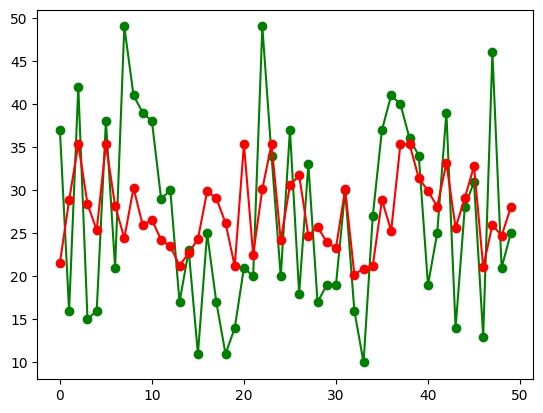

In [12]:
optimizer = torch.optim.SGD(model_RNN.parameters(), lr=hyper[min_err, 0], momentum = hyper[min_err, 1])
epochs = 10
train_rse = 0
mae = 0
size = len(train_loader.dataset)
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_rse_i, y_train, pred_train, mae_t = train_loop( train_loader, model_RNN, loss_fn, optimizer)
  train_rse += train_rse_i
  y_train_tens = torch.hstack(y_train)
  pred_train_tens = torch.hstack(pred_train)
train_rse = train_rse.item()
train_rse /= epochs
mae = mae_t / epochs
fig = plt.figure()
ax1 = fig.add_subplot(111)
print(mae, '\n', mae/deliverytime['Time_taken(min)'].max(),'\n',  mae/deliverytime['Time_taken(min)'].min())
ax1.plot(range(50), y_train_tens.detach().numpy()[3000:3050], 'o-g', pred_train_tens.detach().numpy()[3000:3050], 'o-r' )

There's an high bias


Errore test:  Media loss (Scarto quadratico della stima): 22.246075 
Errore assoluto medio: 547.078430
Coefficiente di determinazione: -81.50043487548828
2.224607467651367 
 0.04119643458613643 
 0.22246074676513672


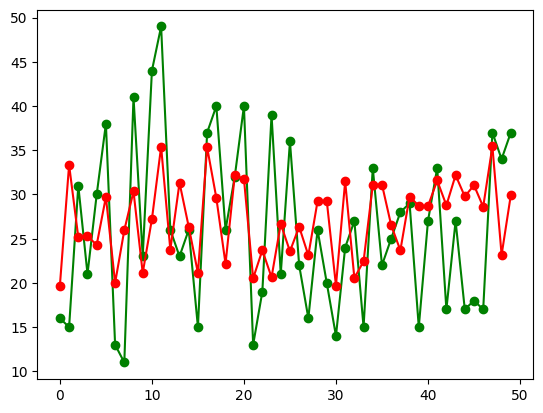

In [13]:
train_rse = 0
size = len(train_loader.dataset)

test_rse, y_test, pred_test, mae = test_loop( train_loader, model_RNN, loss_fn)

y_test_tens = torch.hstack(y_test)
pred_test_tens = torch.hstack(pred_test)

test_rse = test_rse.item()
test_rse /= epochs
print(test_rse, '\n', test_rse/deliverytime['Time_taken(min)'].max(),'\n',  test_rse/deliverytime['Time_taken(min)'].min())
plt.plot(range(50), y_test_tens.detach().numpy()[0:50], 'o-g', pred_test_tens.detach().numpy()[0:50], 'o-r' )